In [89]:
from __future__ import print_function
%matplotlib inline 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import os
import sys
import glob
import h5py
import numpy as np
import math
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset , DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
import tensorboard
import tensorboardX
from torch.utils.tensorboard import SummaryWriter
from log import Logger
from data import trainlabelDataset_reduced, testlabelDataset_reduced
from util import r2, mse, rmse, mae, pp_mse, pp_rmse, pp_mae
from model import  autoencoder_999, autoencoder_333, autoencoder_333_2, autoencoder_1014,autoencoder_1015
from sklearn.decomposition import PCA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [90]:
#batch_size = 64
#learning_rate = 1e-4
#weight=5e4

def showres(path):
    img_data_tensor=torch.load(path)
    img_data= img_data_tensor[4].numpy()
    img_data.resize(64,64)
    plt.imshow(img_data)
    return img_data

def to_img(x):   # image size 56 * 56 
    x = x.view(x.size(0), 1, 64, 64)
    return x


test_dataset = testlabelDataset_reduced()
test_dataloader= DataLoader(dataset=test_dataset, batch_size=300,shuffle=False,drop_last=True)
criterion_none = nn.L1Loss(reduction='none')

0.9801140197515288
0.737297354705269
0.9689865720924349
0.9630378276255172
0.9543141326141434
cov_mean, 0.9207499813577786
-------------------------
[[0.17446043 0.13646712]
 [0.13646712 0.1111235 ]]
correlation 0.9801140197515288


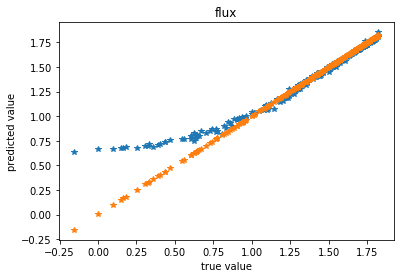

In [222]:
num=11660
#batch_size = 64
#learning_rate = 1e-4
#weight=5e4

model = autoencoder_1015().cuda()   ###### AE model 
#model.load_state_dict(torch.load('gal_img1001/rec002_nonum_{}.pth'.format(num)))    
model.load_state_dict(torch.load('gal_img1001/rec200_3_2_{}.pth'.format(num)))    
model.eval()

num_examples = 0.0
test_num_examples=0.0
test_total_loss = 0.0    
test_total_mse=0.0
test_total_recon=0.0
test_total_latent=0.0
batch_size=300
for data in test_dataloader:
    test_img,test_label= [x.type(torch.float32).cuda() for x in data]
    test_img = test_img.view(test_img.size(0), 1,64,64)
    test_output,test_z = model(test_img)
    test_z=test_z.view(test_z.size(0),14*14)
    

    
    

res_in =  test_img.data.cpu().numpy()   
res_out=test_output.data.cpu().numpy()
label_in=test_label.data.cpu().numpy()
label_out=test_z[:,:5].data.cpu().numpy()


cov_sum=0
for i in range(5):
    cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))

    print(cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))
    cov_sum=cov_sum+cov[0,1]/np.sqrt(cov[0][0] * cov[1][1])
print("cov_mean,",cov_sum/5 )    



flux = (10**label_in[:,0]) * 1.5e6 

    
print("-------------------------")   

i=0
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("flux")
cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))






finished
162
there are 162 out of 196 parameters in Z are zeros. 
Therefore, latent Z has 34 non-zero parameters.


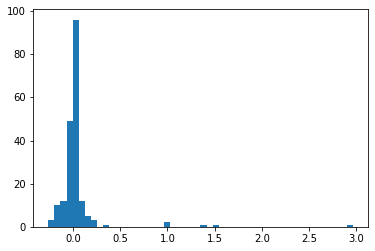

In [223]:

dt_test = test_z.data.cpu().numpy().reshape([300,-1])
print("finished")
mean_expZ=np.mean(dt_test,axis=0)
plt.hist(mean_expZ,bins=50);


counts,edges = np.histogram(mean_expZ)
threshold = 1e-1
zeros = len(np.where(np.abs(mean_expZ)<threshold)[0])
print(zeros)

print("there are",zeros,"out of 196 parameters in Z are zeros. ")
print("Therefore, latent Z has", 14*14-zeros,"non-zero parameters.")

In [224]:
mean_expZ

array([ 1.40210342e+00,  2.96465588e+00,  1.52226520e+00,  9.88207221e-01,
        9.81897891e-01,  9.90778804e-02, -8.50795861e-03, -1.91685930e-02,
        6.25712518e-03,  9.48773418e-03,  1.52242020e-01,  2.47559939e-02,
       -8.09189212e-03,  8.55372474e-03, -5.76667767e-03, -4.09091450e-03,
       -1.01279788e-01, -1.96949188e-02, -1.62480841e-03, -3.32758971e-03,
        1.37349181e-02, -1.69687960e-02,  6.17399625e-03, -2.13897526e-02,
        1.33942878e-02, -3.21152876e-03,  3.03714778e-02,  8.16785172e-03,
        2.90126428e-02,  4.52204719e-02,  4.11543213e-02, -8.40935670e-03,
       -1.43965170e-01, -8.89603049e-03,  1.73256800e-01,  3.23419958e-01,
       -8.95372126e-03, -5.10325767e-02, -1.43503755e-01, -3.28257214e-03,
       -1.81521885e-02,  6.95707696e-03,  1.16580050e-03,  2.62809563e-02,
        7.30227958e-03, -1.05552584e-01, -9.30458587e-03,  1.62340153e-03,
       -2.81492099e-02,  1.31475806e-01, -1.60443075e-02, -2.63084590e-01,
        3.26069072e-02,  

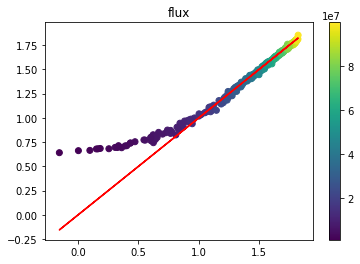

In [225]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.title("flux")
plt.colorbar()

[[0.08162587 0.04472816]
 [0.04472816 0.04508675]]
correlation 0.737297354705269


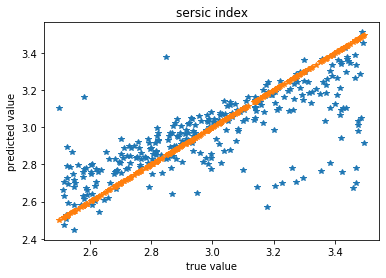

In [226]:
i=1
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("sersic index")

cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))


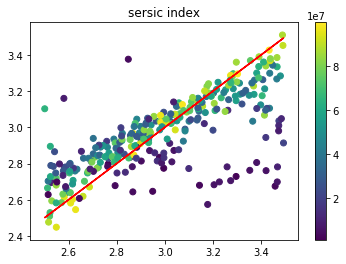

In [227]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.title("sersic index")
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.colorbar()

In [228]:
#label_in[:,i],label_out[:,i]

x_inds = np.where(np.abs(label_in[:,1]-3.4)<0.1)[0]
y_inds = np.where(np.abs(label_out[:,1]-2.8)<0.1)[0]
#x_inds[np.in1d(x_inds,y_inds)]

x_inds[np.in1d(x_inds,y_inds)]



array([ 77, 107, 153, 222])

In [229]:
label_in[50,1]

3.4154055

In [230]:
label_out[50,1]

3.0679317

[[0.68939558 0.60174928]
 [0.60174928 0.55940604]]
correlation 0.9689865720924349


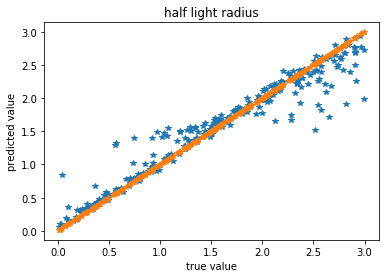

In [231]:
i=2
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("half light radius")

cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))

Text(0.5, 1.0, 'half light radius')

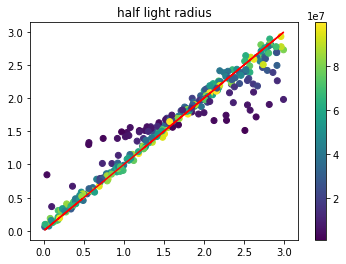

In [232]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.colorbar()
plt.title("half light radius")


[[0.08978914 0.07667758]
 [0.07667758 0.07060351]]
correlation 0.9630378276255172


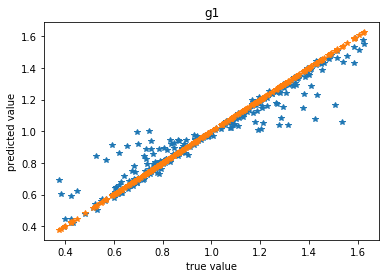

In [233]:
i=3  # q 
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("g1")

cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))

Text(0.5, 1.0, 'g1')

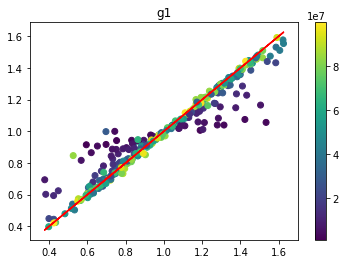

In [234]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.colorbar()
plt.title("g1")


[[0.08903121 0.0749315 ]
 [0.0749315  0.06924747]]
correlation 0.9543141326141434


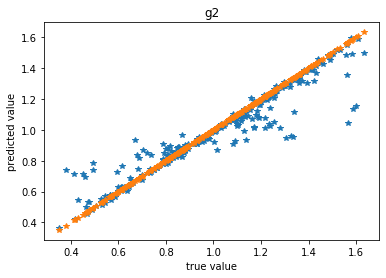

In [235]:
i=4 # u
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.title("g2")

plt.xlabel("true value")
plt.ylabel("predicted value")
cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))


Text(0.5, 1.0, 'g2')

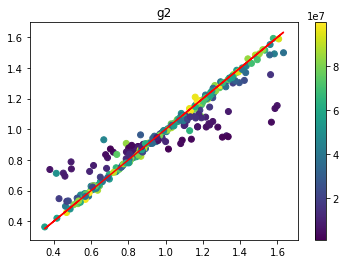

In [236]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.colorbar()
plt.title("g2")

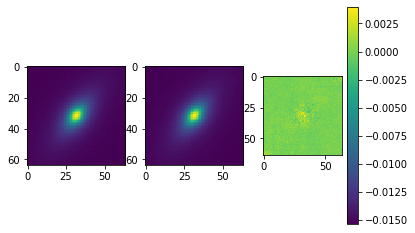

In [237]:
i=28
img_in=res_in[i][0]
img_out=res_out[i][0]

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.subplot(1, 3, 2)  
plt.imshow(img_out) 
plt.subplot(1, 3, 3) 
plt.imshow(img_in-img_out) 
plt.colorbar()

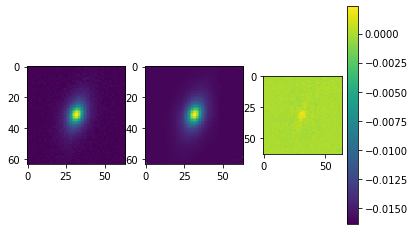

In [238]:
i=10
img_in=res_in[i][0]
img_out=res_out[i][0]

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.subplot(1, 3, 2)  
plt.imshow(img_out) 
plt.subplot(1, 3, 3) 
plt.imshow(img_in-img_out) 
plt.colorbar()

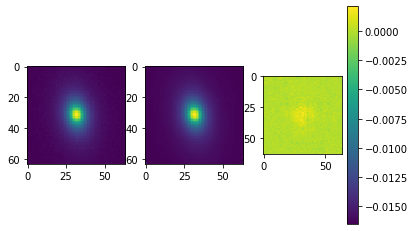

In [239]:
i=60
img_in=res_in[i][0]
img_out=res_out[i][0]

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.subplot(1, 3, 2)  
plt.imshow(img_out) 
plt.subplot(1, 3, 3) 
plt.imshow(img_in-img_out) 
plt.colorbar()

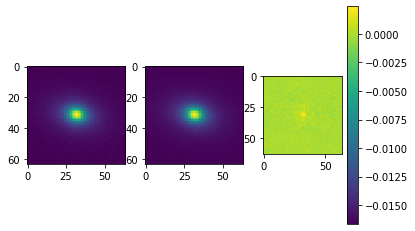

In [240]:
i=69
img_in=res_in[i][0]
img_out=res_out[i][0]

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.subplot(1, 3, 2)  
plt.imshow(img_out) 
plt.subplot(1, 3, 3) 
plt.imshow(img_in-img_out) 
plt.colorbar()

In [245]:
z_mean = mean_expZ
z_new = np.zeros(14*14)
z_new[:5]=z_mean[:5]


In [261]:
z_new_tensor= torch.from_numpy(z_new.astype('float32')).cuda()
z_3= model.lin_2(z_new_tensor)
img=model.decoder(z_3.view(1,1,14,14))

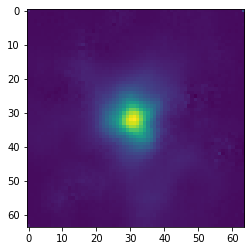

In [271]:
plt.imshow(img.view(64,64).cpu().detach().numpy())